# 第二周模型（1）

准备使用的特征（都没有缺值）：

OverallQual: Rates the overall material and finish of the house(第18列，1-10)

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor 
       
	
YearBuilt: Original construction date(第20列，1872-2010)


以上两个特征不需要处理。


TotalBsmtSF: Total square feet of basement area(第39列，0-6110)

有离群值，但Pedro Marcelino认为不需要处理，确实如此。偏态分布。


GrLivArea: Above grade (ground) living area square feet(第47列，334-5642)

也有离群值，并且偏态分布。


对后两者数值类特征和SalePrice数据，做以下分析和处理。

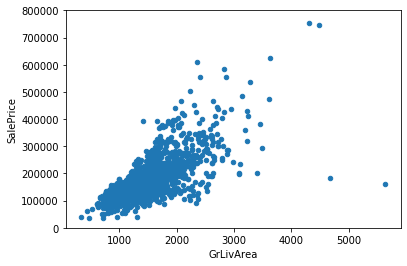

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
df_train = pd.read_csv('train_initial.csv')
# bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

GrLivArea特别大的两个值似乎很奇怪，它们并未跟随趋势。看起来这两点并不代表典型案例。因此，Pedro Marcelino将它们定义为异常值并将这两个样本删除。移除异常值永远是安全的。

图顶部的两个观测值看起来像两种特殊情况，但它们符合趋势。因此，保留它们。

In [2]:
# deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

然后需要对偏态数据正态化。常规的方法是对数变换。Serigne指出在这里Box-Cox变换效果更好，但方便起见这里先用对数变换。

首先是SalePrice。

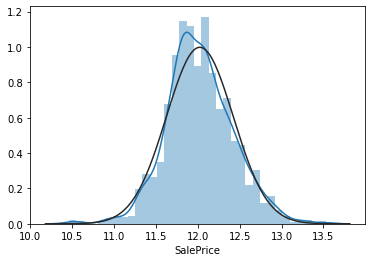

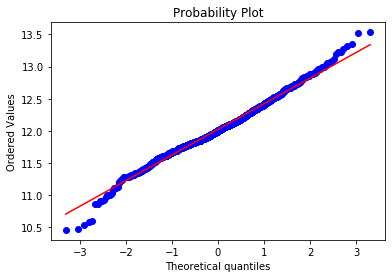

In [3]:
# applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])
# transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

效果很好。

可以发现GrLivArea的分布也是偏态的，所以也进行对数变换。

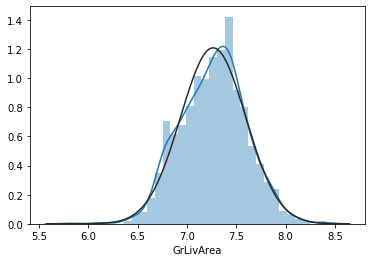

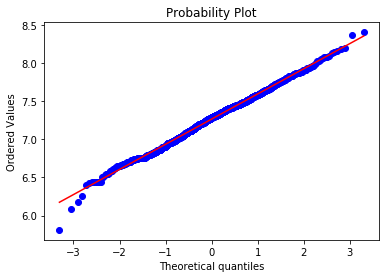

In [4]:
# data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
# transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

效果也还行。然后是TotalBsmtSF。这项数据有些偏斜，但因为很多打工人没有地下室，存在大量0数据，而0无法取对数。

作为尝试，对所有非零观测值进行对数转换，而忽略那些值为零的观测值。

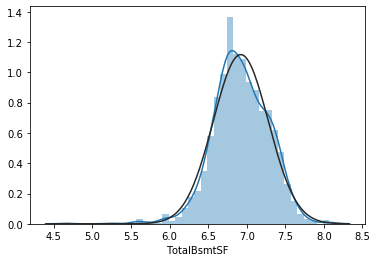

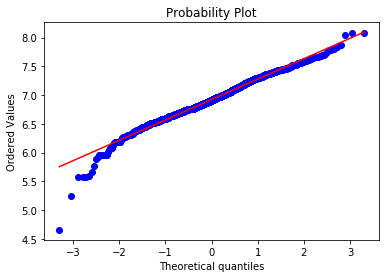

In [5]:
# create column for new variable (one is enough because it's a binary categorical feature)
# if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
# transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])
# histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

老实说，我认为效果不是那么好……只有略微改善。

因为类别变量本就是数字刻画的，不需要转化。

现在，GrLivArea的范围缩小到334-4476。


以上就是本周模型的特征提取与重建部分。

开始线性回归的尝试。

In [49]:
def costFunction(theta, X, y):
    error = np.dot(X, theta) - y
    error = np.squeeze(error)
    cost = np.sum(error**2)/(2 * len(X))
    return cost
def gradientDescent(X, y, theta, alpha, iters):
    temp = np.zeros(theta.shape)
    parameters = int(theta.shape[0])
    cost = np.zeros(iters)
    
    for i in range(iters):
        error = np.dot(X, theta) - y
        error = np.squeeze(error)
        for j in range(parameters):
            X_j = np.squeeze(X[:, j])
            temp[j] = theta[j] - (alpha / len(X)) * np.sum(np.dot(error, X_j))
            
        theta = temp
        cost = np.sum(error**2)/(2 * len(X))
        
    return theta, cost


theta = np.zeros([5, 1])
X = np.empty([len(df_train), 5])
X[:, 0] = 1
X[:, 1] = df_train['OverallQual'].values
X[:, 2] = df_train['YearBuilt'].values
X[:, 3] = df_train['TotalBsmtSF'].values
X[:, 4] = df_train['GrLivArea'].values
y = df_train['SalePrice's].values
theta, cost = gradientDescent(X, y, theta,  1e-12, 1000)
theta = np.squeeze(theta)
cost = costFunction(theta, X, y)

print(theta)
print(cost)

[3.07945408e-06 1.94245022e-05 6.08059844e-03 2.10269805e-05
 2.25172774e-05]
0.054310984946799125


可视化一下结果。

上面梯度下降的过程中，α值取le-13 - le-12，次数取1000-10000时，cost均约为141并趋于141.13左右，说明该假设函数在这个训练样本下的极限就是如此。

接下来进行岭回归。lambda设为0.01只是暂时的。

In [15]:
def ridgeGradientDescent(X, y, theta, alpha, iters, lambdas):
    temp = np.zeros(theta.shape)
    parameters = int(theta.shape[0])
    cost = np.zeros(iters)
    
    for i in range(iters):
        error = np.dot(X, theta) - y
        error = np.squeeze(error)
        for j in range(parameters):
            X_j = np.squeeze(X[:, j])
            if(j == 0):
                temp[j] = theta[j] - (alpha / len(X)) * np.sum(np.dot(error, X_j))
            else:
                temp[j] = theta[j] - (alpha / len(X)) * (np.sum(np.dot(error, X_j)) + lambdas * theta[j])
            
        theta = temp
        cost = np.sum(error**2)/(2 * len(X))
        
    return theta, cost


theta = np.zeros([5, 1])
X = np.empty([len(df_train), 5])
X[:, 0] = 1
X[:, 1] = df_train['OverallQual'].values
X[:, 2] = df_train['YearBuilt'].values
X[:, 3] = df_train['TotalBsmtSF'].values
X[:, 4] = df_train['GrLivArea'].values
y = df_train['SalePrice'].values
theta, cost = ridgeGradientDescent(X, y, theta,  1e-12, 10000, 0.01)
print(cost)

141.13474092134868


划分训练集为训练集和测试集，轮换数据。要求文档并没有禁止此处使用sklearn。

In [6]:
from sklearn.model_selection import train_test_split
def ridgeGradientDescent(X, y, theta, alpha, iters, lambdas):
    temp = np.zeros(theta.shape)
    parameters = int(theta.shape[0])
    cost = np.zeros(iters)
    
    for i in range(iters):
        error = np.dot(X, theta) - y
        error = np.squeeze(error)
        for j in range(parameters):
            X_j = np.squeeze(X[:, j])
            if(j == 0):
                temp[j] = theta[j] - (alpha / len(X)) * np.sum(np.dot(error, X_j))
            else:
                temp[j] = theta[j] - (alpha / len(X)) * (np.sum(np.dot(error, X_j)) + lambdas * theta[j])
            
        theta = temp
        cost = np.sum(error**2)/(2 * len(X))
        
    return theta, cost


theta = np.zeros([5, 1])
X = np.empty([len(df_train), 5])
X[:, 0] = 1
X[:, 1] = df_train['OverallQual'].values
X[:, 2] = df_train['YearBuilt'].values
X[:, 3] = df_train['TotalBsmtSF'].values
X[:, 4] = df_train['GrLivArea'].values
y = df_train['SalePrice'].values
for i in range(1, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = i)
    theta, cost = ridgeGradientDescent(X_train, y_train, theta,  1e-12, 1000, 0.01)
print(cost)

128.3383901363899


效果不错。接下来开始测试。

In [12]:
# test
df_test = pd.read_csv('test.csv')
y_test = np.empty([len(df_test)])
X_test = np.empty([len(df_test), 5])
X_test[:, 0] = 1
X_test[:, 1] = df_test['OverallQual'].values
X_test[:, 2] = df_test['YearBuilt'].values
X_test[:, 3] = df_test['TotalBsmtSF'].values
X_test[:, 4] = df_test['GrLivArea'].values
y_test = np.squeeze(np.exp(np.dot(X_test, theta)))
print(y_test)

[163114.14993588 163431.47852337 206884.4130472  ... 164637.00145262
 197539.91644742 203974.97929143]


第二个项目明确要求模型训练不能用机器学习函数，所以还是重写吧。

In [8]:
def trainTestSplit(X, y, seed):
    X_train = []
    y_train = []
    np.random.seed(seed)
    for i in range(len(y)):
        if np.random.randint(0,10) != seed:
            X_train.append(X[i, :])
            y_train.append(y[i])
    return X_train, y_train


def ridgeGradientDescent(X, y, theta, alpha, iters, lambdas):
    temp = np.zeros(theta.shape)
    parameters = int(theta.shape[0])
    cost = np.zeros(iters)
    
    for i in range(iters):
        error = np.dot(X, theta) - y
        error = np.squeeze(error)
        for j in range(parameters):
            X_j = np.squeeze(X[:, j])
            if(j == 0):
                temp[j] = theta[j] - (alpha / len(X)) * np.sum(np.dot(error, X_j))
            else:
                temp[j] = theta[j] - (alpha / len(X)) * (np.sum(np.dot(error, X_j)) + lambdas * theta[j])
            
        theta = temp
        cost = np.sum(error**2)/(2 * len(X))
        
    return theta, cost


theta = np.zeros([5, 1])
X = np.empty([len(df_train), 5])
X[:, 0] = 1
X[:, 1] = df_train['OverallQual'].values
X[:, 2] = df_train['YearBuilt'].values
X[:, 3] = df_train['TotalBsmtSF'].values
X[:, 4] = df_train['GrLivArea'].values
y = df_train['SalePrice'].values
for i in range(0, 9):
    X_train, y_train = trainTestSplit(X, y, i)
    theta, cost = ridgeGradientDescent(X_train, y_train, theta,  1e-12, 1000, 0.01)
print(cost)

TypeError: list indices must be integers or slices, not tuple

In [12]:
import scipy.optimize as opt

def trainTestSplit(X, y, seed):
    X_train = []
    y_train = []
    np.random.seed(seed)
    for i in range(len(y)):
        if np.random.randint(10) != seed:
            X_train.append(X[i, :])
            y_train.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train


def ridgeGradientDescent(theta, X, y):
    alpha = 0.000001
    lambdas = 0.01
    iters = 10
    temp = np.zeros(theta.shape)
    parameters = int(theta.shape[0])
    
    for i in range(iters):
        error = np.dot(X, theta) - y
        error = np.squeeze(error)
        for j in range(parameters):
            X_j = np.squeeze([x[j] for x in X])
            if(j == 0):
                temp[j] = theta[j] - (alpha / len(X)) * np.sum(np.dot(error, X_j))
            else:
                temp[j] = theta[j] - (alpha / len(X)) * (np.sum(np.dot(error, X_j)) + lambdas * theta[j])
            
        theta = temp
        
    return theta

def costFunction(theta, X, y):
    error = np.dot(X, theta) - y
    error = np.squeeze(error)
    cost = np.sum(error**2)/(2 * len(X))
    return cost


theta = np.zeros(5)
X = np.empty([len(df_train),5])
X[:, 0] = 1
X[:, 1] = df_train['OverallQual'].values
X[:, 2] = df_train['YearBuilt'].values
X[:, 3] = df_train['TotalBsmtSF'].values
X[:, 4] = df_train['GrLivArea'].values
y = df_train['SalePrice'].values

for i in range(10):
    X_train, y_train = trainTestSplit(X, y, i)
    temp = opt.fmin_tnc(func = costFunction, x0 = theta.flatten(), fprime = ridgeGradientDescent, args = (X_train, y_train.flatten()))
    theta = temp[0]
cost = costFunction(theta, X, y)
print(cost)

0.05359161201430138


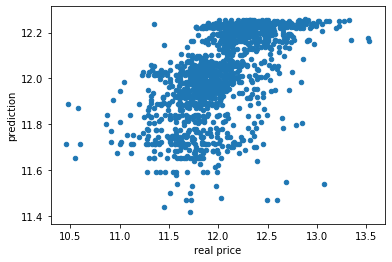

In [39]:
predictions = pd.DataFrame({"real price":y, "prediction":np.squeeze(np.dot(X, theta))})
predictions.plot(x = "real price", y = "prediction", kind = "scatter")

In [25]:
# test
df_test = pd.read_csv('test.csv')
y_test = np.empty([len(df_test)])
X_test = np.empty([len(df_test), 5])
X_test[:, 0] = 1
X_test[:, 1] = df_test['OverallQual'].values
X_test[:, 2] = df_test['YearBuilt'].values
X_test[:, 3] = df_test['TotalBsmtSF'].values
X_test[:, 4] = df_test['GrLivArea'].values
y_test = np.squeeze(np.exp(np.dot(X_test, theta)))
print(y_test)

[156823.30646113 156968.69736535 198639.90922167 ... 158161.40004712
 189789.46417696 195780.4511219 ]
